https://www.kaggle.com/code/jimbothehut/content-based-manga-recommender-system/notebook

https://github.com/kk7nc/Text_Classification#rocchio-classification

https://queryunderstanding.com/query-expansion-2d68d47cf9c8


In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer,  CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import math
import string
from itertools import groupby
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
def remove_stop_words(text):
    sc   = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation) #remove punctuations
    text = text.translate(translator)
    return text

def lowercase(text):
  return text.lower()

def preprocess(text):
  text = lowercase(text)
  text = remove_punctuation(text)
  text = remove_stop_words(text)
  return text

In [ ]:
keywords = open("/gdrive/MyDrive/keywords.txt").readlines()
keywords = [x.strip() for x in keywords]

In [ ]:
documents = open("/gdrive/MyDrive/documents.txt", encoding='utf-8-sig').read().split('\n\n')
documents = [x.replace('\n', ' ').replace('...', '').replace('�', '').replace('.  ', '.') for x in documents]

In [ ]:
process_docs = [preprocess(x).lower() for x in documents]

In [ ]:
def wordcount(doc): #frequency of word in docs
  word_count = defaultdict(int)
  for sentence in doc:
    for word in sentence.split():
      word_count[word] += 1
  word_count = dict(sorted(word_count.items(), key = lambda x : x[1], reverse = True)) #descending
  return word_count

In [ ]:
def zipf_plot(doc): #word to frequency
  word_count = wordcount(doc)
  plt.figure(figsize = (50, 10))
  plt.tight_layout()
  plt.xlabel('Words', fontsize = 27)
  plt.ylabel('Frequency', fontsize = 27)
  plt.xticks(rotation=90, fontsize = 5)
  plt.bar(word_count.keys(), word_count.values())

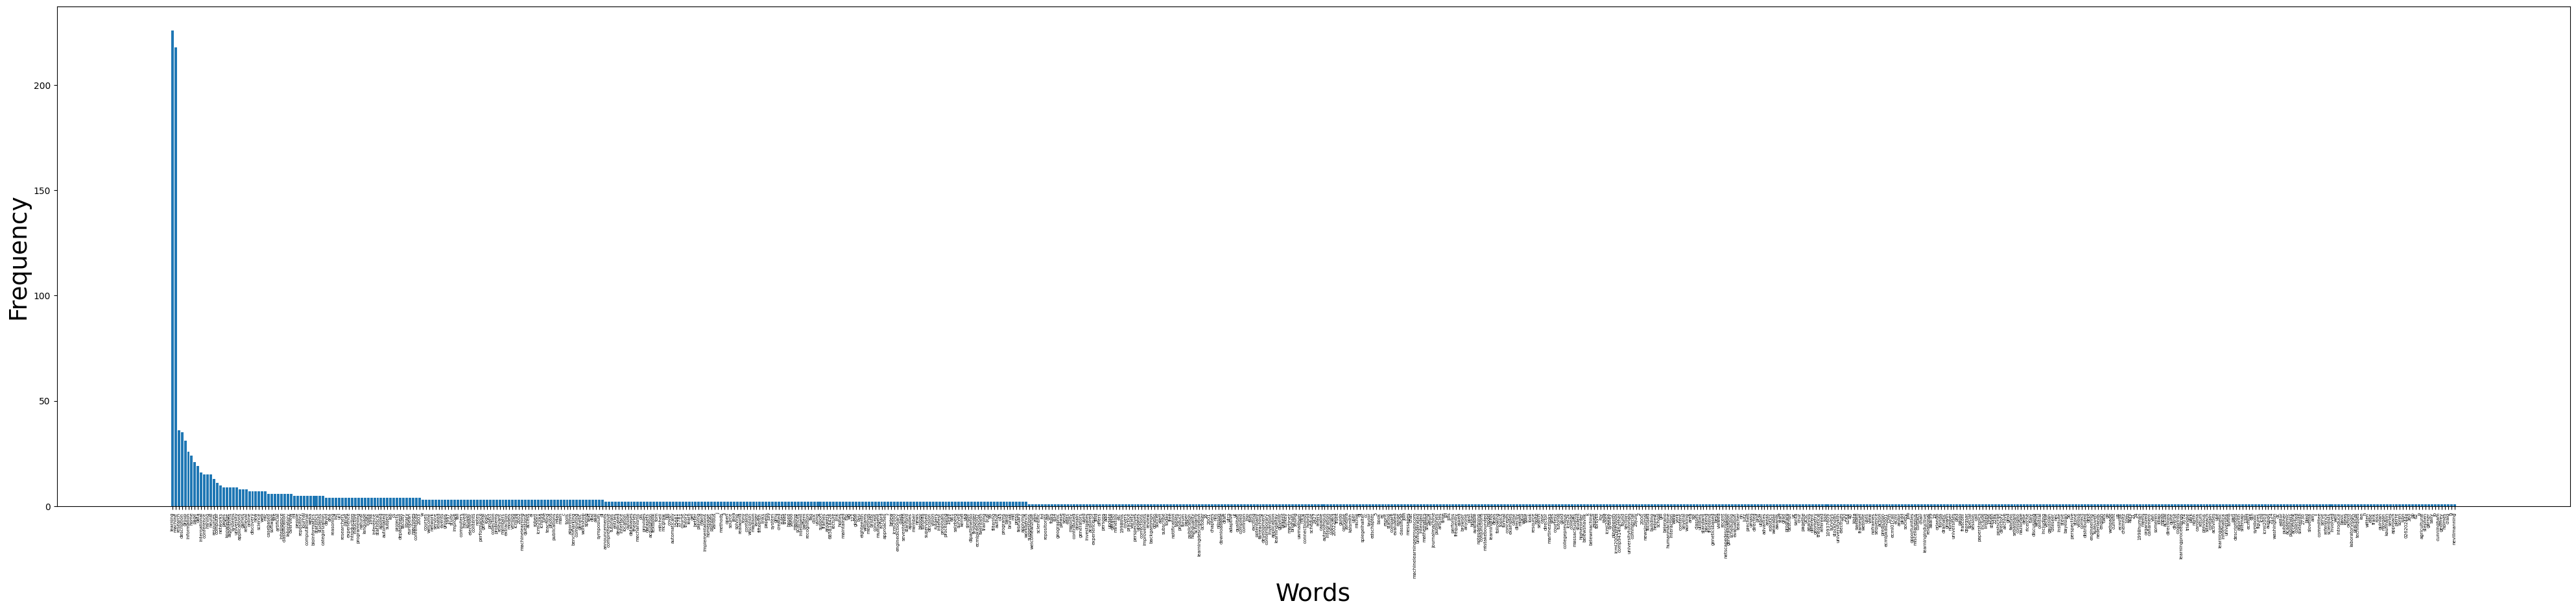

In [ ]:
zipf_plot(process_docs)

In [ ]:
def heaps_plot(doc): #no.of unique words and vocab size
    frequency = []
    for i in doc:
        f = len(i)
        l = []
        c = 0
        for j in i:#each word in doc
          if j not in l:
            c+=1
            l.append(j)
        frequency.append([f, c])
    frequency.sort(reverse = True)
    x, y = [t[0] for t in frequency], [t[1] for t in frequency]
    plt.plot(x,y)

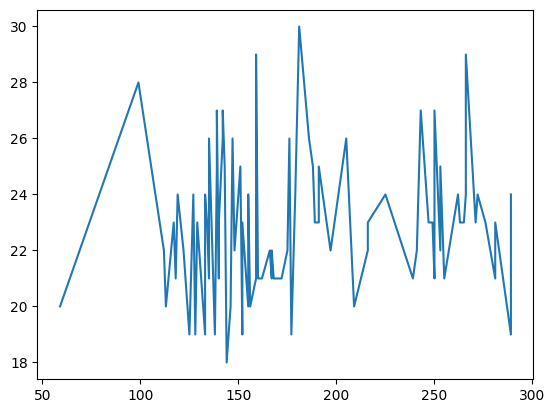

In [ ]:
heaps_plot(process_docs)

In [ ]:
vectorizer = TfidfVectorizer(vocabulary=keywords)
X = vectorizer.fit_transform(process_docs)
print(X.shape)

(88, 120)


In [ ]:
def cosine_sim(query, X):
    q_tfidf = vectorizer.fit_transform([query])
    results = cosine_similarity(X,q_tfidf).reshape((-1,))
    return results

In [ ]:
def query_search(results):
    print("Top 10 Documents matched: ")
    j = 0
    res = []
    for i in results.argsort()[-10:][::-1]:
        j += 1
        print("Document {:02d}: ".format(j), documents[i])
        res.append(documents[i])
    return res

In [ ]:
def get_relevance(results):
    res_bool = []
    for x in range(len(results)):
        ch = input(f"Type R or N for document {x+1} being relevant and non-relevant respectively: ")
        if ch == 'R' or ch == 'r':
            res_bool.append(True)
        else:
            res_bool.append(False)
    return res_bool

In [ ]:
def get_vectors(docs):
    vec = []
    for x in docs:
        i = documents.index(x)
        vec.append(X[i]) # taking that document's TF_idf matrix - row
    return vec

In [ ]:
def rocchio_rel(query, vectors, rel_vec, alpha=1, beta=0.8, gamma=0.1):
    rels_ = [vectors[i] for i in range(len(vectors)) if rel_vec[i] == True]
    non_rels = [vectors[i] for i in range(len(vectors)) if rel_vec[i] == False]
    C1 = sum(rels_) / len(rels_)
    C2 = sum(non_rels) / len(non_rels)
    q = vectorizer.fit_transform([query])
    q1 = alpha * q + beta * C1 - gamma * C2 #formula
    results = cosine_similarity(X,q1).reshape((-1,))
    return results

In [ ]:
query = 'neural machine learning'
query_docs = query_search(cosine_sim(query, X))

Top 10 Documents matched: 
Document 01:  15-681 and 15-781 Machine Learning Machine Learning, 15:681 and 15:781, Fall 1998.This course covers the theory and practice of machine learning from a variety of perspectives.
Document 02:  C4.5: Programs for Machine Learning By Author. C4.5: Programs for Machine Learning J. Ross Quinlan, The Morgan Kaufmann Series in Machine  
Document 03:  Machine Learning Machine Learning, THE  Machine learning refers to a system capable of the autonomous acquisition and integration of knowledge. This  
Document 04:  Machine Learning 6.858/18.428: Machine Learning. Available Lecture Notes.Defining models for machine learning. Learning conjunctions in the mistake-bounded model.
Document 05:  Machine Learning 6.858/18.428: Machine Learning.This course deals with the following topics: Formal models of machine learning; Learning concepts from examples;  
Document 06:  Machine Learning FAQ Machine Learning FAQ. Machine Learning Frequently Asked Questions. Click H

In [ ]:
relevance = get_relevance(query_docs)
tfidf_vectors = get_vectors(query_docs)
rocchio_results = rocchio_rel(query, tfidf_vectors, relevance)
q_docs = query_search(rocchio_results)

KeyboardInterrupt: ignored

In [ ]:
countvect = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
count_docs = countvect.fit_transform(process_docs)

In [ ]:
NUM_TOPICS = 10
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, learning_method='online',verbose=True)
data_lda = lda.fit_transform(count_docs)

In [ ]:
def selected_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names_out()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])

In [ ]:
print('LDA Model: ')
selected_topics(lda, countvect)